In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
print(tf.__version__)
print(keras.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))




2.10.1
2.10.0
Num GPUs Available:  1


# Task 1

## 2.
1. Fashion MNIST 
- Loading data
- creating train, validation and test set 
- create class names


In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                   "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

#num_classes = 10
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_valid = keras.utils.to_categorical(y_valid, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

- create model 

In [5]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[28, 28], opt = "SGD"): 
    model = keras.models.Sequential() 
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = eval("".join(["keras.optimizers.",opt, "(lr=learning_rate)"]))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])
    return model

In [6]:
keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)


C:\Users\felix.wente\AppData\Local\Temp\ipykernel_15800\657781944.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [8]:
keras_reg.fit(X_train, y_train, epochs=100,
            validation_data=(X_valid, y_valid),
            callbacks=[keras.callbacks.EarlyStopping(patience=5, min_delta=0.001)])
mse_test = keras_reg.score(X_test, y_test)

Epoch 1/100
1719/1719 [==============================] - 4s 2ms/step - loss: 1.1187 - accuracy: 0.6492 - val_loss: 0.7663 - val_accuracy: 0.7566
Epoch 2/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7064 - accuracy: 0.7700 - val_loss: 0.6392 - val_accuracy: 0.7958
Epoch 3/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6191 - accuracy: 0.7956 - val_loss: 0.5797 - val_accuracy: 0.8160
Epoch 4/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5720 - accuracy: 0.8099 - val_loss: 0.5445 - val_accuracy: 0.8220
Epoch 5/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5412 - accuracy: 0.8185 - val_loss: 0.5198 - val_accuracy: 0.8296
Epoch 6/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5194 - accuracy: 0.8250 - val_loss: 0.4996 - val_accuracy: 0.8370
Epoch 7/100
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5024 - accuracy: 0.8299 - val_loss: 0.4886 - val_ac

In [9]:
param_distribs = {
        "n_hidden": [0, 1, 2, 3],
        "n_neurons": np.arange(1, 100),
        "learning_rate": reciprocal(3e-4, 3e-2),
        "opt": ["SGD","Adam"],
}

In [ ]:
# this runs for 43 minutes
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=300,
                batch_size=50,
                validation_data=(X_valid, y_valid),
                callbacks=[keras.callbacks.EarlyStopping(patience=3, min_delta=0.001)])

In [ ]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)

In [ ]:
model = rnd_search_cv.best_estimator_.model
model.evaluate(X_test, y_test)
model.save("models/MLP_brute.h5")

Optimizing search with KerasTuner:
- l1&l2 regularization slowed down the search process by a lot

In [10]:
hp = keras_tuner.HyperParameters()
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 6)):
        if i==0:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i}",default=100, min_value=30, max_value=515, step=25),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))
        if i==1:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i}",default=300, min_value=30, max_value=515, step=50),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))
        if i==2:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i}",default=300, min_value=30, max_value=515, step=50),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))

        if i==3:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i}",default=300, min_value=30, max_value=515, step=50),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))

        if i==4:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i}",default=300, min_value=30, max_value=515, step=50),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))
        
        else:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i}",default=100, min_value=30, max_value=515, step=50),
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                ))
        
        if hp.Boolean(f"dropout_{i+1}", default=True):
            model.add(layers.Dropout(rate=hp.Choice(f'rate_{i+1}', default=0.25, values = [0.25,0.5,0.75])))



    model.add(layers.Dense(10, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model(keras_tuner.HyperParameters())

choosing tuner: https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f

In [36]:
Tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=30,
    num_initial_points=2,
    seed=90,
    directory="Task1",
    project_name="MLP",
    #overwrite=True,
)


INFO:tensorflow:Reloading Oracle from existing project Task1\MLP\oracle.json
INFO:tensorflow:Reloading Tuner from Task1\MLP\tuner0.json


In [8]:
Tuner.search_space_summary()


Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': 100, 'conditions': [], 'min_value': 30, 'max_value': 515, 'step': 25, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_1 (Boolean)
{'default': True, 'conditions': []}
rate_1 (Choice)
{'default': 0.25, 'conditions': [], 'values': [0.25, 0.5, 0.75], 'ordered': True}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [12]:
Tuner.search(X_train, y_train, epochs=200,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)],
            validation_data=(X_valid, y_valid),batch_size=250)


Trial 7 Complete [00h 00m 23s]
val_accuracy: 0.8992000222206116

Best val_accuracy So Far: 0.906000018119812
Total elapsed time: 00h 04m 47s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
505               |505               |units_0
tanh              |tanh              |activation
False             |False             |dropout_1
0.25              |0.25              |rate_1
0.00017276        |0.00052555        |lr
330               |130               |units_1
False             |False             |dropout_2
0.25              |0.25              |rate_2
430               |430               |units_2
True              |True              |dropout_3
0.25              |0.25              |rate_3
480               |480               |units_3
False             |True              |dropout_4
0.25              |0.25              |rate_4
30                |80                |units_4
True              |True              |

KeyboardInterrupt: 

In [37]:

# Get the top 3 models.
models_mlp = Tuner.get_best_models(num_models=3)
best_model_mlp = models_mlp[0]

# Build model for Fashion MNIST 
best_model_mlp.build(input_shape=(None, 28, 28))




best_model_mlp.summary()
Tuner.results_summary()
best_model_mlp.evaluate(X_test, y_test)


best_hp_mlp = Tuner.get_best_hyperparameters(3)
mlp_set1 = Tuner.hypermodel.build(best_hp_mlp[0])
mlp_set2 = Tuner.hypermodel.build(best_hp_mlp[1])
mlp_set3 = Tuner.hypermodel.build(best_hp_mlp[2])

#best_model_mlp.save("models/best_mlp.h5")
#best_model_mlp2.save("models/best_mlp2.h5")
#best_model_mlp3.save("models/best_mlp3.h5")




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 505)               396425    
                                                                 
 dense_1 (Dense)             (None, 505)               255530    
                                                                 
 dense_2 (Dense)             (None, 10)                5060      
                                                                 
Total params: 657,015
Trainable params: 657,015
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in Task1\MLP
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 1
units_0: 505
activation: tanh
dropout_1: False
rate_1: 0.25
lr: 0.00052555368

Epoch 1/200
220/220 [==============================] - 1s 4ms/step - loss: 0.5430 - accuracy: 0.8052 - val_loss: 0.4070 - val_accuracy: 0.8568
Epoch 2/200
220/220 [==============================] - 0s 2ms/step - loss: 0.4016 - accuracy: 0.8552 - val_loss: 0.3646 - val_accuracy: 0.8702
Epoch 3/200
220/220 [==============================] - 0s 2ms/step - loss: 0.3681 - accuracy: 0.8659 - val_loss: 0.3965 - val_accuracy: 0.8532
Epoch 4/200
220/220 [==============================] - 0s 2ms/step - loss: 0.3437 - accuracy: 0.8750 - val_loss: 0.3443 - val_accuracy: 0.8748
Epoch 5/200
220/220 [==============================] - 0s 2ms/step - loss: 0.3263 - accuracy: 0.8801 - val_loss: 0.3450 - val_accuracy: 0.8780
Epoch 6/200
220/220 [==============================] - 0s 2ms/step - loss: 0.3089 - accuracy: 0.8868 - val_loss: 0.3295 - val_accuracy: 0.8844
Epoch 7/200
220/220 [==============================] - 1s 2ms/step - loss: 0.2949 - accuracy: 0.8917 - val_loss: 0.3143 - val_accuracy: 0.8868

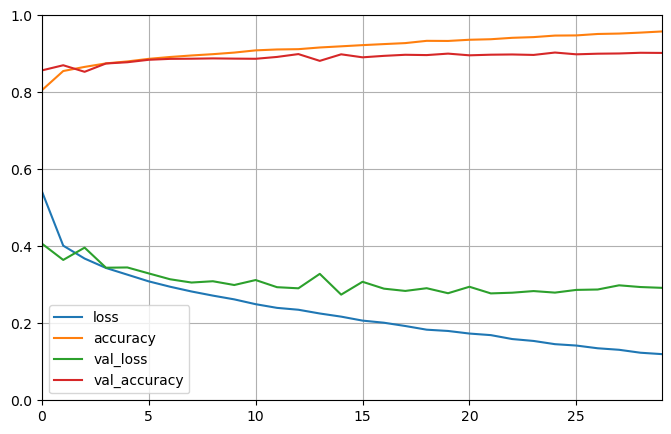

In [15]:
history = mlp_set1.fit(X_train, y_train, epochs=200,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)],
            batch_size=250,validation_data=(X_valid, y_valid))

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
plt.gca().set_xlim(0,29)
plt.show()

## CNN

In [4]:
hp = keras_tuner.HyperParameters()
def build_model_cnn(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_fixed_filter',default=96, min_value=32, max_value=128, step=10),
        # adding kernel size
        kernel_size=hp.Choice('conv_fixed_kernel', values = [3,5,7]),
        #activation function
        activation='relu',
        input_shape=[28,28,1],
        padding='same',)
    )
    model.add(
    layers.MaxPooling2D(2),
    ),

    # Tune the number of layers.
    for i in range(hp.Int("num_cnn_layers",default=2, min_value=1, max_value=3)):
        if i == 0:
            model.add(
                layers.Conv2D(
                    #adding filter 
                    filters=hp.Int(f'conv_{i+1}_filter',default=256, min_value=32, max_value=512, step=16),
                    # adding kernel size
                    kernel_size=hp.Choice(f'conv_{i+1}_kernel', values = [3,5]),
                    #activation function
                    activation='relu',
                    padding='same'),
            )

        elif i == 1:
            model.add(
                layers.Conv2D(
                    #adding filter 
                    filters=hp.Int(f'conv_{i+1}_filter',default=348, min_value=32, max_value=512, step=16),
                    # adding kernel size
                    kernel_size=hp.Choice(f'conv_{i+1}_kernel', values = [3,5]),
                    #activation function
                    activation='relu',
                    padding='same'),
            )

        elif i == 2:
            model.add(
                layers.Conv2D(
                    #adding filter 
                    filters=hp.Int(f'conv_{i+1}_filter',default=348, min_value=32, max_value=512, step=16),
                    # adding kernel size
                    kernel_size=hp.Choice(f'conv_{i+1}_kernel', values = [3,5]),
                    #activation function
                    activation='relu',
                    padding='same'),
            )

        else:
            model.add(
                layers.Conv2D(
                    #adding filter 
                    filters=hp.Int(f'conv_{i+1}_filter',default=256, min_value=32, max_value=512, step=16),
                    # adding kernel size
                    kernel_size=hp.Choice(f'conv_{i+1}_kernel', values = [3,5]),
                    #activation function
                    activation='relu',
                    padding='same'),
            )

        model.add(
            layers.MaxPooling2D(
                pool_size = 2
            ),
            )
                
    model.add(layers.Flatten())        

    for i in range(hp.Int("num_dense_layers", default=2, min_value=1, max_value=3)):
        if i == 0:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i+1}",default=128, min_value=60, max_value=515, step=20),
                    activation=hp.Choice("activation", ["relu", "tanh"]),),
            )
        
        elif i == 1:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i+1}",default=60, min_value=60, max_value=515, step=20),
                    activation=hp.Choice("activation", ["relu", "tanh"]),),
            )

        else:
            model.add(
                layers.Dense(
                    units=hp.Int(f"units_{i+1}",default=60, min_value=60, max_value=515, step=20),
                    activation=hp.Choice("activation", ["relu", "tanh"]),),
            )

        if hp.Boolean(f"dropout_{i+1}", default=True):
            model.add(layers.Dropout(rate=hp.Choice(f'rate_{i+1}', default=0.25, values = [0.25,0.5,0.75])))
    
    model.add(layers.Dense(10, activation="softmax"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model_cnn(keras_tuner.HyperParameters())

In [5]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model_cnn,
    objective="val_accuracy",
    max_trials=20,
    num_initial_points=2,
    seed=90,
    directory="Task1",
    project_name="CNN",
    #overwrite=True,
    #executions_per_trial,
)

INFO:tensorflow:Reloading Oracle from existing project Task1\CNN\oracle.json
INFO:tensorflow:Reloading Tuner from Task1\CNN\tuner0.json


In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 16
conv_fixed_filter (Int)
{'default': 96, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 10, 'sampling': None}
conv_fixed_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
num_cnn_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
conv_1_filter (Int)
{'default': 256, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': 348, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
num_dense_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': 128, 'conditions': [], 'min_value': 60, 'max_val

In [21]:
tuner.search(X_train, y_train, epochs=250,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)],
            validation_data=(X_valid, y_valid), batch_size=300)



Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
42                |102               |conv_fixed_filter
3                 |3                 |conv_fixed_kernel
1                 |1                 |num_cnn_layers
192               |160               |conv_1_filter
5                 |5                 |conv_1_kernel
512               |432               |conv_2_filter
3                 |5                 |conv_2_kernel
1                 |1                 |num_dense_layers
60                |160               |units_1
tanh              |tanh              |activation
False             |False             |dropout_1
0.25              |0.25              |rate_1
340               |380               |units_2
False             |False             |dropout_2
0.75              |0.75              |rate_2
0.0001            |0.00014949        |lr

Epoch 1/250
184/184 [==============================] - 2s 10ms/step - loss: 0.9174 - accuracy: 0.7095 - val_loss: 0.5582 - 

KeyboardInterrupt: 

In [6]:
# Get the top 3 models.
models_cnn = tuner.get_best_models(num_models=3)
best_model_cnn = models_cnn[0]

# Build model for Fashion MNIST 
best_model_cnn.build(input_shape=(None, 28, 28))




best_model_cnn.summary()
tuner.results_summary()
best_model_cnn.evaluate(X_test, y_test)


best_hp_cnn = tuner.get_best_hyperparameters(3)
cnn_set1 = tuner.hypermodel.build(best_hp_cnn[0])
cnn_set2 = tuner.hypermodel.build(best_hp_cnn[1])
cnn_set3 = tuner.hypermodel.build(best_hp_cnn[2])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 102)       1020      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 102)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 160)       408160    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 160)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7840)              0         
                                                                 
 dense (Dense)               (None, 160)               1

Epoch 1/200
220/220 [==============================] - 3s 11ms/step - loss: 0.6727 - accuracy: 0.7637 - val_loss: 0.4383 - val_accuracy: 0.8412
Epoch 2/200
220/220 [==============================] - 2s 10ms/step - loss: 0.3967 - accuracy: 0.8592 - val_loss: 0.3595 - val_accuracy: 0.8768
Epoch 3/200
220/220 [==============================] - 2s 10ms/step - loss: 0.3462 - accuracy: 0.8764 - val_loss: 0.3225 - val_accuracy: 0.8882
Epoch 4/200
220/220 [==============================] - 2s 10ms/step - loss: 0.3144 - accuracy: 0.8872 - val_loss: 0.3073 - val_accuracy: 0.8918
Epoch 5/200
220/220 [==============================] - 2s 10ms/step - loss: 0.2928 - accuracy: 0.8949 - val_loss: 0.2876 - val_accuracy: 0.9002
Epoch 6/200
220/220 [==============================] - 2s 10ms/step - loss: 0.2767 - accuracy: 0.9015 - val_loss: 0.2842 - val_accuracy: 0.9012
Epoch 7/200
220/220 [==============================] - 2s 10ms/step - loss: 0.2564 - accuracy: 0.9095 - val_loss: 0.2641 - val_accuracy:

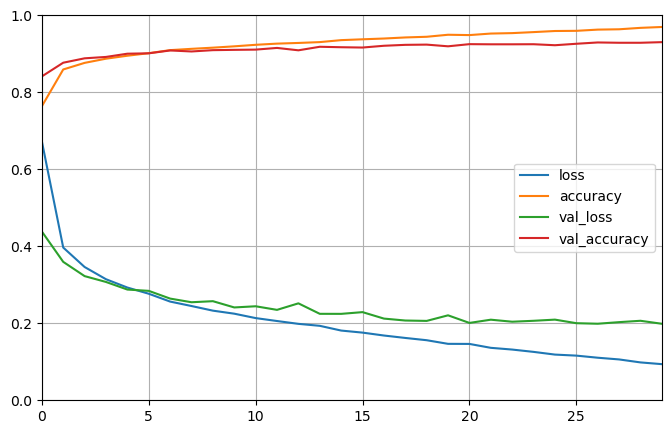

In [23]:
history = cnn_set1.fit(X_train, y_train, epochs=200,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)],
            batch_size=250,validation_data=(X_valid, y_valid))

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
plt.gca().set_xlim(0,29)
plt.show()

## CIFAR10

In [7]:
cifar10 = keras.datasets.cifar10
(x_train_full_cif, y_train_full_cif), (x_test_full_cif, y_test_full_cif) = cifar10.load_data()
X_valid, X_train = x_train_full_cif[:5000] / 255.0, x_train_full_cif[5000:] / 255.0
y_valid, y_train = y_train_full_cif[:5000], y_train_full_cif[5000:]


Epoch 1/250
225/225 [==============================] - 1s 3ms/step - loss: 1.9514 - accuracy: 0.3113 - val_loss: 1.7577 - val_accuracy: 0.3596
Epoch 2/250
225/225 [==============================] - 1s 3ms/step - loss: 1.6996 - accuracy: 0.3931 - val_loss: 1.6461 - val_accuracy: 0.4092
Epoch 3/250
225/225 [==============================] - 1s 3ms/step - loss: 1.6063 - accuracy: 0.4279 - val_loss: 1.5944 - val_accuracy: 0.4340
Epoch 4/250
225/225 [==============================] - 1s 3ms/step - loss: 1.5658 - accuracy: 0.4419 - val_loss: 1.5595 - val_accuracy: 0.4424
Epoch 5/250
225/225 [==============================] - 1s 3ms/step - loss: 1.5057 - accuracy: 0.4636 - val_loss: 1.5186 - val_accuracy: 0.4566
Epoch 6/250
225/225 [==============================] - 1s 3ms/step - loss: 1.4846 - accuracy: 0.4716 - val_loss: 1.4755 - val_accuracy: 0.4716
Epoch 7/250
225/225 [==============================] - 1s 3ms/step - loss: 1.4304 - accuracy: 0.4892 - val_loss: 1.5116 - val_accuracy: 0.4518

[1.7562161684036255, 0.4756999909877777]

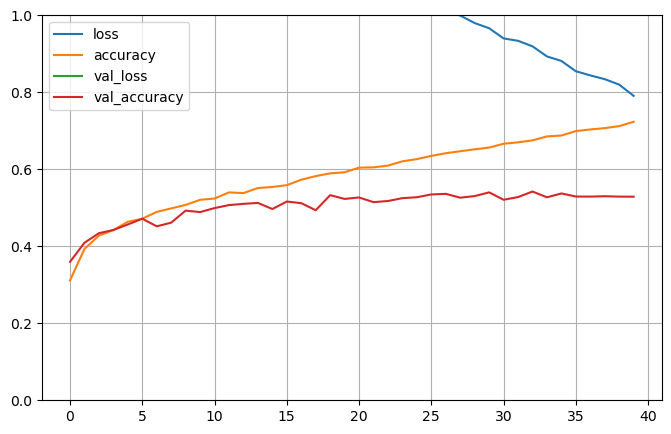

In [38]:
history = mlp_set1.fit(X_train, y_train, epochs=250,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)], 
                        validation_data=(X_valid, y_valid),batch_size = 200)
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()
mlp_set1.evaluate(x_test_full_cif, y_test_full_cif)

Epoch 1/250
225/225 [==============================] - 1s 5ms/step - loss: 2.0050 - accuracy: 0.2557 - val_loss: 1.8617 - val_accuracy: 0.3198
Epoch 2/250
225/225 [==============================] - 1s 4ms/step - loss: 1.8481 - accuracy: 0.3245 - val_loss: 1.7659 - val_accuracy: 0.3662
Epoch 3/250
225/225 [==============================] - 1s 4ms/step - loss: 1.7825 - accuracy: 0.3560 - val_loss: 1.7447 - val_accuracy: 0.3706
Epoch 4/250
225/225 [==============================] - 1s 4ms/step - loss: 1.7366 - accuracy: 0.3731 - val_loss: 1.7337 - val_accuracy: 0.3746
Epoch 5/250
225/225 [==============================] - 1s 4ms/step - loss: 1.7257 - accuracy: 0.3793 - val_loss: 1.7382 - val_accuracy: 0.3748
Epoch 6/250
225/225 [==============================] - 1s 4ms/step - loss: 1.6965 - accuracy: 0.3881 - val_loss: 1.6744 - val_accuracy: 0.3946
Epoch 7/250
225/225 [==============================] - 1s 4ms/step - loss: 1.6804 - accuracy: 0.3977 - val_loss: 1.7161 - val_accuracy: 0.3808

[1.968817949295044, 0.36800000071525574]

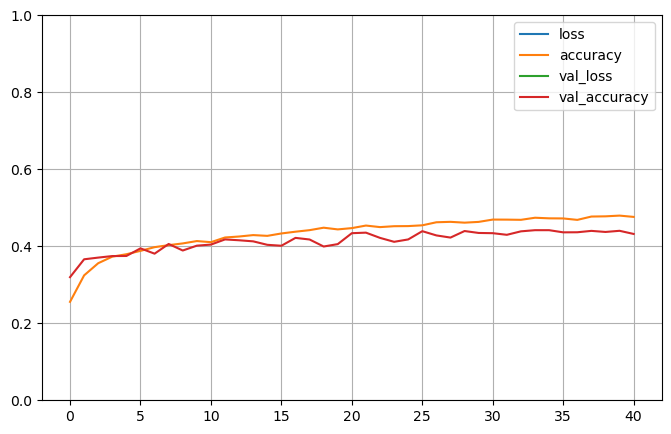

In [39]:
history = mlp_set2.fit(X_train, y_train,epochs=250,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)], 
                        validation_data=(X_valid, y_valid),batch_size = 200)
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()
mlp_set2.evaluate(x_test_full_cif, y_test_full_cif)

Epoch 1/250
225/225 [==============================] - 2s 6ms/step - loss: 1.9757 - accuracy: 0.2712 - val_loss: 1.7666 - val_accuracy: 0.3694
Epoch 2/250
225/225 [==============================] - 1s 5ms/step - loss: 1.7809 - accuracy: 0.3533 - val_loss: 1.6566 - val_accuracy: 0.4056
Epoch 3/250
225/225 [==============================] - 1s 5ms/step - loss: 1.6861 - accuracy: 0.3938 - val_loss: 1.5879 - val_accuracy: 0.4272
Epoch 4/250
225/225 [==============================] - 1s 5ms/step - loss: 1.6311 - accuracy: 0.4138 - val_loss: 1.5595 - val_accuracy: 0.4418
Epoch 5/250
225/225 [==============================] - 1s 5ms/step - loss: 1.5914 - accuracy: 0.4316 - val_loss: 1.5533 - val_accuracy: 0.4418
Epoch 6/250
225/225 [==============================] - 1s 5ms/step - loss: 1.5565 - accuracy: 0.4433 - val_loss: 1.5480 - val_accuracy: 0.4440
Epoch 7/250
225/225 [==============================] - 1s 5ms/step - loss: 1.5232 - accuracy: 0.4548 - val_loss: 1.4930 - val_accuracy: 0.4642

[2.3885936737060547, 0.3855000138282776]

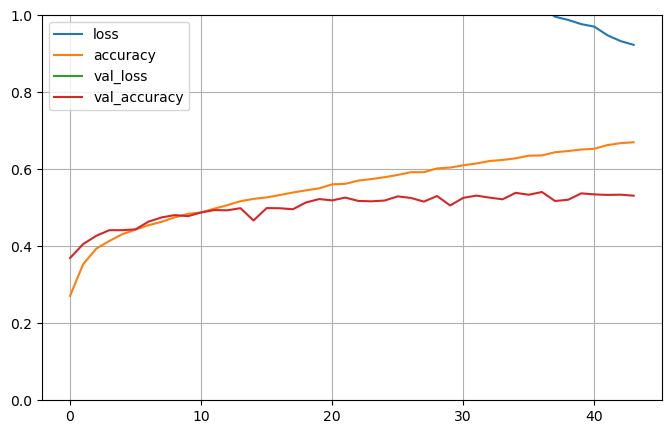

In [40]:
history = mlp_set3.fit(X_train, y_train, epochs=250,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)], 
                        validation_data=(X_valid, y_valid),batch_size = 200)
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()
mlp_set3.evaluate(x_test_full_cif, y_test_full_cif)

### CNN

In [8]:
cnn_set1.summary()
tuner.results_summary(1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 102)       1020      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 102)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 160)       408160    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 160)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 7840)              0         
                                                                 
 dense_2 (Dense)             (None, 160)              

Epoch 1/250
225/225 [==============================] - 3s 11ms/step - loss: 1.6569 - accuracy: 0.4142 - val_loss: 1.3731 - val_accuracy: 0.5120
Epoch 2/250
225/225 [==============================] - 2s 11ms/step - loss: 1.2845 - accuracy: 0.5501 - val_loss: 1.1911 - val_accuracy: 0.5784
Epoch 3/250
225/225 [==============================] - 2s 10ms/step - loss: 1.1531 - accuracy: 0.5988 - val_loss: 1.1075 - val_accuracy: 0.6094
Epoch 4/250
225/225 [==============================] - 2s 11ms/step - loss: 1.0621 - accuracy: 0.6303 - val_loss: 1.0425 - val_accuracy: 0.6278
Epoch 5/250
225/225 [==============================] - 2s 11ms/step - loss: 0.9910 - accuracy: 0.6556 - val_loss: 1.0451 - val_accuracy: 0.6306
Epoch 6/250
225/225 [==============================] - 2s 11ms/step - loss: 0.9433 - accuracy: 0.6755 - val_loss: 0.9627 - val_accuracy: 0.6592
Epoch 7/250
225/225 [==============================] - 2s 11ms/step - loss: 0.8961 - accuracy: 0.6913 - val_loss: 0.9322 - val_accuracy:

[1.7598074674606323, 0.6315000057220459]

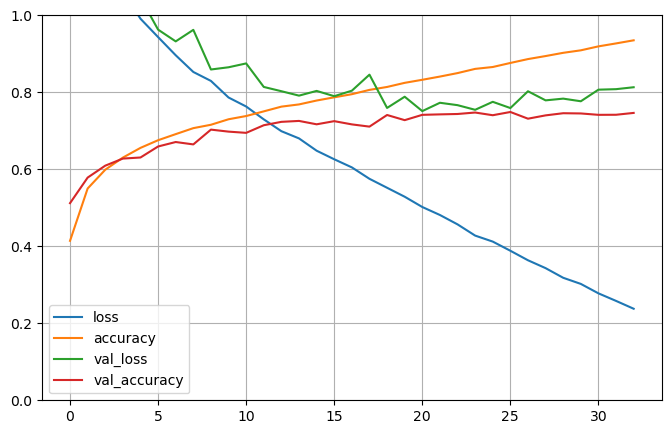

In [12]:
cifar_cnn1 = keras.models.Sequential([
    keras.layers.Conv2D(102, 3, activation='relu', padding='same', 
                        input_shape=[32,32,3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(160, 5, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(160, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')
])

cifar_cnn1.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=0.00014948684422968163),
                  metrics=['accuracy'])

history = cifar_cnn1.fit(X_train, y_train, epochs=250,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)], 
                        validation_data=(X_valid, y_valid),batch_size = 200)

pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()
cifar_cnn1.evaluate(x_test_full_cif, y_test_full_cif)

In [11]:
cnn_set2.summary()
tuner.results_summary(2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 92)        920       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 92)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 512)       1178112   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 512)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 80)               

Epoch 1/250
225/225 [==============================] - 6s 22ms/step - loss: 1.6746 - accuracy: 0.4072 - val_loss: 1.3993 - val_accuracy: 0.5112
Epoch 2/250
225/225 [==============================] - 5s 21ms/step - loss: 1.3267 - accuracy: 0.5326 - val_loss: 1.2331 - val_accuracy: 0.5712
Epoch 3/250
225/225 [==============================] - 5s 21ms/step - loss: 1.1909 - accuracy: 0.5851 - val_loss: 1.1457 - val_accuracy: 0.6014
Epoch 4/250
225/225 [==============================] - 5s 21ms/step - loss: 1.0994 - accuracy: 0.6197 - val_loss: 1.0803 - val_accuracy: 0.6214
Epoch 5/250
225/225 [==============================] - 5s 21ms/step - loss: 1.0214 - accuracy: 0.6485 - val_loss: 1.0029 - val_accuracy: 0.6466
Epoch 6/250
225/225 [==============================] - 5s 21ms/step - loss: 0.9685 - accuracy: 0.6661 - val_loss: 0.9622 - val_accuracy: 0.6614
Epoch 7/250
225/225 [==============================] - 5s 21ms/step - loss: 0.9214 - accuracy: 0.6836 - val_loss: 0.9482 - val_accuracy:

[1.5418496131896973, 0.6378999948501587]

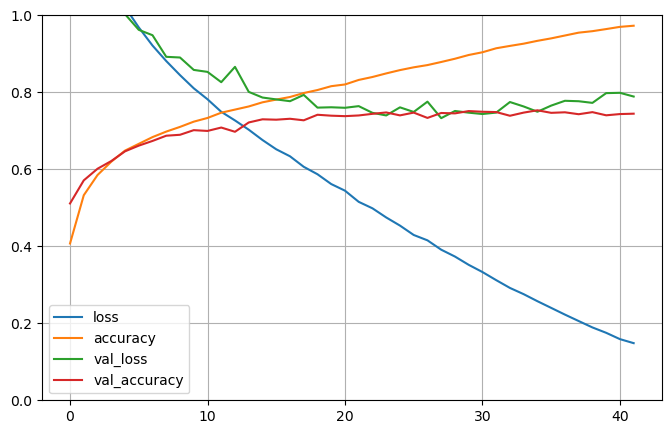

In [15]:
cifar_cnn2 = keras.models.Sequential([
    keras.layers.Conv2D(92, 3, activation='relu', padding='same', 
                        input_shape=[32,32,3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(512, 5, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(80, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')
])

cifar_cnn2.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001
),
                  metrics=['accuracy'])

history = cifar_cnn2.fit(X_train, y_train, epochs=250,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)], 
                        validation_data=(X_valid, y_valid),batch_size = 200)

pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()
cifar_cnn2.evaluate(x_test_full_cif, y_test_full_cif)

In [14]:
cnn_set3.summary()
tuner.results_summary(3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 92)        920       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 92)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 224)       515424    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 224)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 10976)             0         
                                                                 
 dense_6 (Dense)             (None, 400)              

Epoch 1/250
225/225 [==============================] - 4s 15ms/step - loss: 1.6592 - accuracy: 0.4124 - val_loss: 1.3782 - val_accuracy: 0.5168
Epoch 2/250
225/225 [==============================] - 3s 15ms/step - loss: 1.2918 - accuracy: 0.5501 - val_loss: 1.2247 - val_accuracy: 0.5802
Epoch 3/250
225/225 [==============================] - 3s 15ms/step - loss: 1.1549 - accuracy: 0.5987 - val_loss: 1.1512 - val_accuracy: 0.5918
Epoch 4/250
225/225 [==============================] - 3s 15ms/step - loss: 1.0642 - accuracy: 0.6304 - val_loss: 1.0271 - val_accuracy: 0.6398
Epoch 5/250
225/225 [==============================] - 3s 14ms/step - loss: 1.0047 - accuracy: 0.6526 - val_loss: 1.0330 - val_accuracy: 0.6428
Epoch 6/250
225/225 [==============================] - 3s 14ms/step - loss: 0.9457 - accuracy: 0.6752 - val_loss: 0.9582 - val_accuracy: 0.6598
Epoch 7/250
225/225 [==============================] - 3s 14ms/step - loss: 0.9034 - accuracy: 0.6893 - val_loss: 0.9181 - val_accuracy:

[3.3942675590515137, 0.6205000281333923]

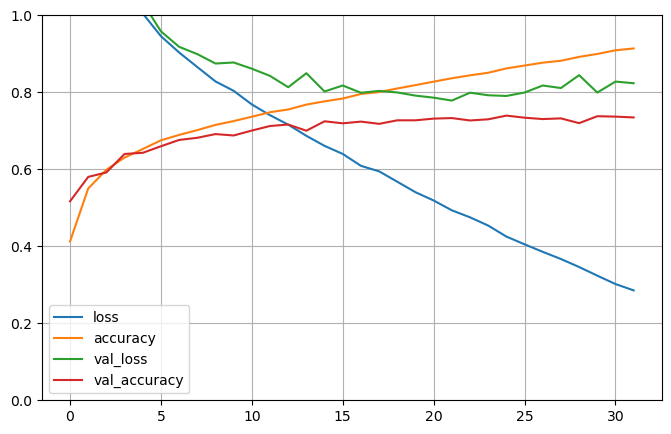

In [16]:
cifar_cnn3 = keras.models.Sequential([
    keras.layers.Conv2D(92, 3, activation='relu', padding='same', 
                        input_shape=[32,32,3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(224, 5, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(400, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')
])

cifar_cnn3.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001
),
                  metrics=['accuracy'])

history = cifar_cnn3.fit(X_train, y_train, epochs=250,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)], 
                        validation_data=(X_valid, y_valid),batch_size = 200)

pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()
cifar_cnn3.evaluate(x_test_full_cif, y_test_full_cif)